In [ ]:
#imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline
import plotly.offline as pyo
import plotly.graph_objs as go

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 0. Загрузка дата сета

In [ ]:
#data-loading function
def load_data(path_to_data):
  df = pd.read_csv(path_to_data, delimiter = ',', names=['Price', 'Volume', 'Floor/MaxFloor', 'District', 'Rooms', 'URL', 'Street', 'Time'])
  return df

path_to_data = "/content/drive/My Drive/ML/prepared_data.csv"
dataset = load_data(path_to_data)
#test output
print(dataset.head())

     Price  Volume  ...          Street  Time
0  8004700   38.30  ...  УлицаГорчакова   5.0
1  7795333   37.80  ...        Ольховая   5.0
2  6877690   39.10  ...      ФилатовЛуг   5.0
3  6359004   36.53  ...      Силикатная   6.0
4  9200000   46.10  ...      Коммунарка  15.0

[5 rows x 8 columns]


# 1. Разведочный аназил данных(EDA)

Ниже представлена диаграмма, на которой представленны данные о числе представителей различных полов

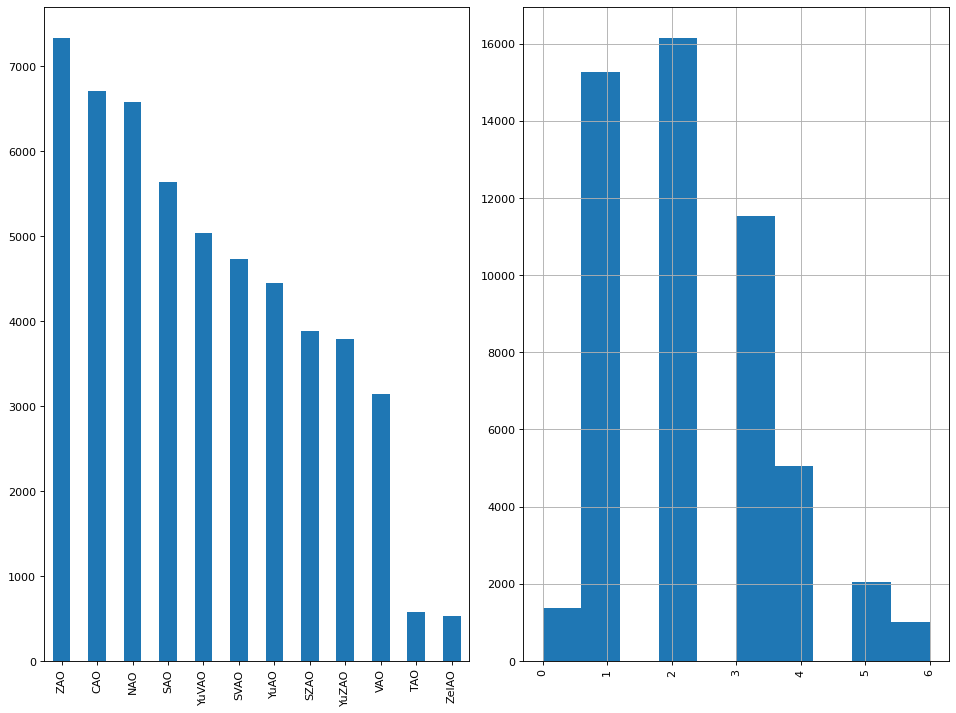

In [ ]:
# Statistic data 
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] 
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.xticks(rotation = 90)
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

plotPerColumnDistribution(dataset, dataset.shape[0], dataset.shape[1])    

Как можно заметить больше всего объявлений в ЗАО и САО. Также преобладают объявления 1-комн. и 2-комн. квартир. Под 0 значением определены студии

Приведем общее описание датасета:

In [ ]:
dataset.describe()

,Price,Volume,Rooms,Time
count,5.241400e+04,52414.000000,52414.000000,52262.000000
mean,3.104572e+07,77.617856,2.264433,9.191171
std,6.337786e+07,61.454380,1.262225,5.390886
min,1.100000e+06,10.000000,0.000000,1.000000
25%,9.336286e+06,41.005000,1.000000,5.000000
50%,1.361075e+07,58.700000,2.000000,8.000000
75%,2.514493e+07,87.040000,3.000000,12.000000
max,2.688196e+09,1040.000000,6.000000,87.000000


Как можно заметить Время до ближайшего транспорта указано не везде, поэтому далее отпросим такие объявления

In [ ]:
#delete duplicates from dataset
dataset = dataset.drop_duplicates()
dataset.shape
# delete row with no data in its values
dataset = dataset.dropna()
dataset.count()

Price             52262
Volume            52262
Floor/MaxFloor    52262
District          52262
Rooms             52262
URL               52262
Street            52262
Time              52262
dtype: int64

# 2. Генерация признаков на тестовых данных

Генерация признаков

In [ ]:
def set_features(data):
  vol = data['Volume'].to_numpy()
  dist = pd.factorize(data['District'])[0]
  floor = data['Floor'].to_numpy()
  maxFloor = data['MaxFloor'].to_numpy()
  street = pd.factorize(data['Street'])[0]
  time = data['Time'].to_numpy()
  feature_set = np.stack((vol, dist, floor, maxFloor, street, time), axis=1)
  return feature_set

dataset[['Floor', 'MaxFloor']] = dataset['Floor/MaxFloor'].str.split('/', 1, expand=True)
dataset
X = set_features(dataset)
X

array([[38.3, 0, '3', '9', 0, 5.0],
       [37.8, 0, '7', '16', 1, 5.0],
       [39.1, 0, '1', '9', 2, 5.0],
       ...,
       [39.8, 5, '8', '12', 129, 5.0],
       [47.0, 5, '12', '14', 142, 8.0],
       [37.2, 5, '2', '9', 141, 4.0]], dtype=object)

 Генерация меток

In [ ]:
Y = dataset['Price'].to_numpy()
Y

array([8004700, 7795333, 6877690, ..., 9300000, 9300000, 9250000])

# 3. Построение моделей регрессии

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import math
train_splitting = 0.1 # cuz no dev set 98% train and 2% test

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=train_splitting, random_state=1, shuffle=False)

## 3.1 Linear regression

In [ ]:
Lin_model = LinearRegression().fit(X_train, Y_train)

In [ ]:
Y_pred = Lin_model.predict(X_test)

Max_deviation:  117348923.49444176
Min_deviation:  2955.85276061669
Arithmetic_mean:  8767423.228780739
MAE:  8767423.228780752
RMSE:  132652533493972.11
R^2:  -0.7494602189520467


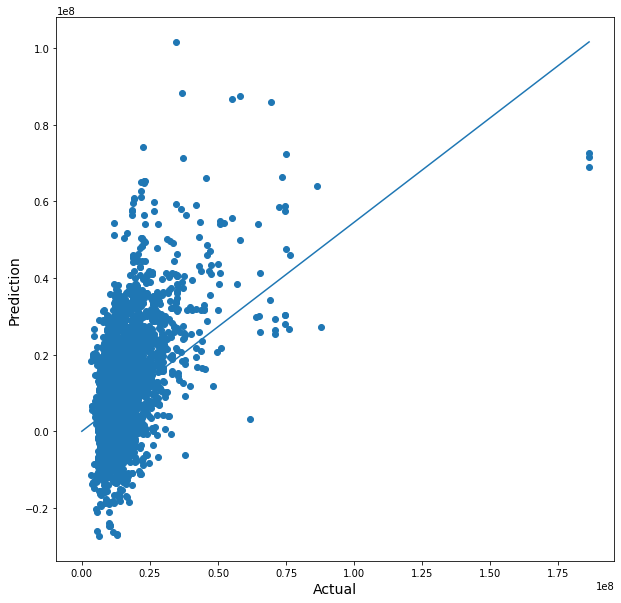

In [ ]:
def check_error(Y_pred, Y_test):
  sum = 0.0
  max_deviation = 0
  min_deviation = 10**10

  for i, elem in enumerate(Y_test):
    sum += math.fabs(Y_pred[i]-elem)
    if math.fabs(Y_pred[i]-elem) > max_deviation:
      max_deviation = math.fabs(Y_pred[i]-elem)
    if math.fabs(Y_pred[i] - elem) < min_deviation:
      min_deviation = math.fabs(Y_pred[i]-elem)

  print("Max_deviation: ", max_deviation)
  print("Min_deviation: ", min_deviation)
  print("Arithmetic_mean: ", sum/len(Y_pred))
  print("MAE: ", mean_absolute_error(Y_test, Y_pred))
  print("RMSE: ", mean_squared_error(Y_test, Y_pred))
  print("R^2: ", r2_score(Y_test, Y_pred))
  plt.figure(figsize=(10, 10))
  plt.scatter(Y_test, Y_pred)
  plt.plot([0, max(Y_test)], [0, max(Y_pred)])
  plt.xlabel('Actual', fontsize=14)
  plt.ylabel('Prediction', fontsize=14)

check_error(Y_pred, Y_test)

## 3.2 XGBoost

In [ ]:
train = xgb.DMatrix(X_train, Y_train)
test = xgb.DMatrix(X_test, Y_test)
epos = 10

In [ ]:
param = {'max_depth': 10, 'eta': 0.5, 'nthread': 6, 'eval_metric': 'rmse', 'objective': 'reg:squarederror'}
evallist = [(test, 'eval'), (train, 'train')]

In [ ]:
XGBoost_model = xgb.train(param, train, epos, evallist)

[0]	eval-rmse:9.17368e+06	train-rmse:4.39889e+07
[1]	eval-rmse:6.1761e+06	train-rmse:2.87404e+07
[2]	eval-rmse:4.88716e+06	train-rmse:2.15163e+07
[3]	eval-rmse:4.36352e+06	train-rmse:1.80016e+07
[4]	eval-rmse:3.9134e+06	train-rmse:1.56566e+07
[5]	eval-rmse:3.69009e+06	train-rmse:1.44156e+07
[6]	eval-rmse:3.64788e+06	train-rmse:1.36941e+07
[7]	eval-rmse:3.59465e+06	train-rmse:1.32181e+07
[8]	eval-rmse:3.59297e+06	train-rmse:1.25226e+07
[9]	eval-rmse:3.54165e+06	train-rmse:1.22351e+07


In [ ]:
XGBoost_model.predict(test)

array([0.00248589, 0.00241918, 0.00246895, ..., 0.00241918, 0.9985152 ,
       0.9988558 ], dtype=float32)

In [ ]:
Y_pred = [int(round(x)) for x in XGBoost_model.predict(test)]

Max_deviation:  49116009.0
Min_deviation:  418.0
Arithmetic_mean:  2052136.9416491296
MAE:  2052136.9416491296
RMSE:  12543255365290.113
R^2:  0.8345758976497117


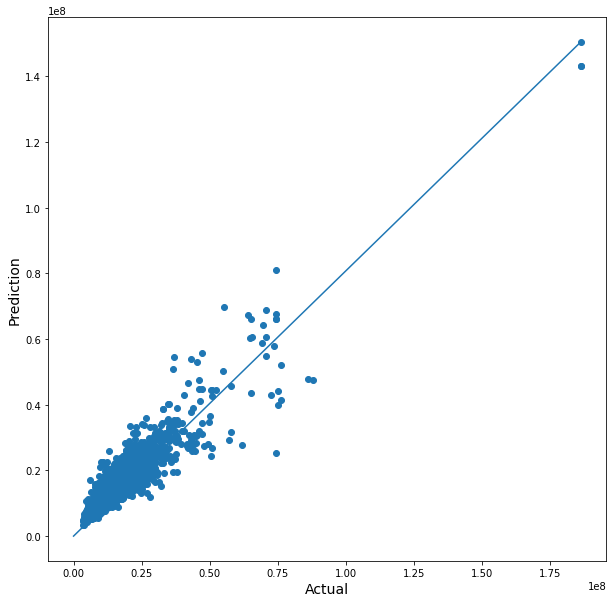

In [ ]:
check_error(Y_pred, Y_test)

## 3.3 LightGBM

In [ ]:
LightGBM_train = lgb.Dataset(X_train, label=Y_train)
LightGBM_test = lgb.Dataset(X_test, label=Y_test)

In [ ]:
param = {'num_leaves': 50, 'metric': 'rmse', 'learning_rate': 0.5, 'boosting_type': 'gbdt', 'max_depth': 10}

In [ ]:
LightGBM_model = lgb.train(param, LightGBM_train, epos)

In [ ]:
Y_pred = LightGBM_model.predict(X_test)

array([ 9536608.88075958, 10018906.98219196, 15925913.38148217, ...,
       13274574.53078984, 15924102.82800278, 11192329.6775042 ])

Max_deviation:  117348923.49444176
Min_deviation:  2955.85276061669
Arithmetic_mean:  8767423.228780739
MAE:  8767423.228780752
RMSE:  132652533493972.11
R^2:  0.1538187043417718


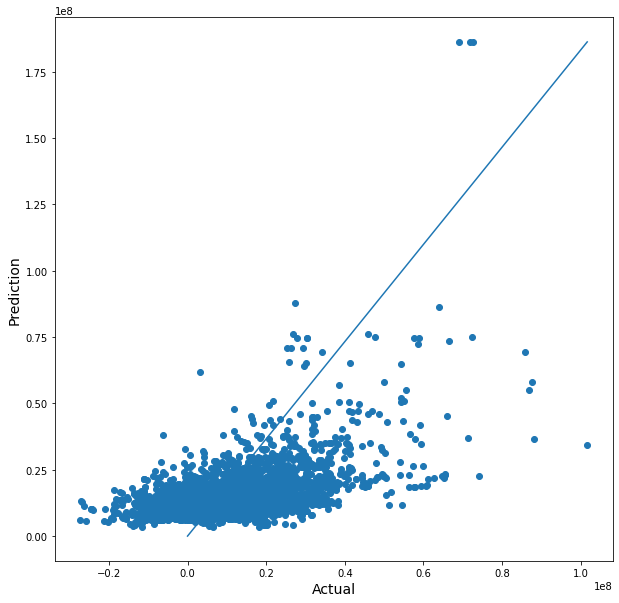

In [ ]:
check_error(Y_test, Y_pred)

## 3.4 CatBoost

In [ ]:
!pip install catboost

     |████████████████████████████████| 65.8MB 62kB/s 


In [ ]:
from catboost import CatBoostRegressor

In [ ]:
cat = CatBoostRegressor(iterations=100, 
                          depth=16, 
                          learning_rate=0.5, 
                          loss_function='RMSE')

In [ ]:
cat.fit(X_train,Y_train)

0:	learn: 45940382.1287095	total: 1.64s	remaining: 2m 42s
1:	learn: 36218619.4215582	total: 2.45s	remaining: 1m 59s
2:	learn: 30606296.8254295	total: 3.22s	remaining: 1m 44s
3:	learn: 27074834.9912653	total: 3.99s	remaining: 1m 35s
4:	learn: 24669271.5742589	total: 4.79s	remaining: 1m 30s
5:	learn: 23027930.5984823	total: 5.56s	remaining: 1m 27s
6:	learn: 21800887.3983549	total: 6.4s	remaining: 1m 25s
7:	learn: 20566535.4055184	total: 7.18s	remaining: 1m 22s
8:	learn: 19856826.4216361	total: 7.95s	remaining: 1m 20s
9:	learn: 19405729.0745827	total: 8.74s	remaining: 1m 18s
10:	learn: 18875480.6045678	total: 9.51s	remaining: 1m 16s
11:	learn: 18542099.7691809	total: 10.3s	remaining: 1m 15s
12:	learn: 18188145.2914758	total: 11.1s	remaining: 1m 14s
13:	learn: 17941300.8752638	total: 11.9s	remaining: 1m 12s
14:	learn: 17559826.9707324	total: 12.7s	remaining: 1m 11s
15:	learn: 17032025.4857813	total: 13.4s	remaining: 1m 10s
16:	learn: 16874959.7697549	total: 14.3s	remaining: 1m 9s
17:	learn

In [ ]:
Y_pred = cat.predict(X_test)

Max_deviation:  49272655.074370936
Min_deviation:  268.75051023066044
Arithmetic_mean:  1955758.158177394
MAE:  1955758.1581773981
RMSE:  10625800981829.64
R^2:  0.8329703637648265


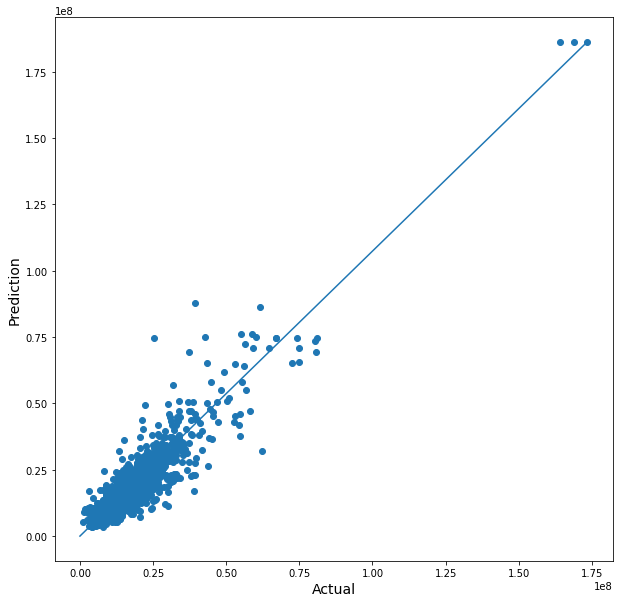

In [ ]:
check_error(Y_test, Y_pred)